In [256]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split
import math
import random
from random import uniform

In this TP, you will see how to use random forest for classifiation.
We will use the dataset with handwritten digits as in the second exercice of last TP (decision trees)
You will first apply random forest to the raw images and then try to improve the performance using HOG representations of images.

In [257]:
mnist = pd.read_csv('cp_sample.csv', sep=';')

Question : Split this dataset into training/validation/test (you can use the same split as last TP)

In [258]:
data_train, data_test = train_test_split(mnist, test_size = 0.3, random_state = 24)
data_valid, data_test = train_test_split(data_test, test_size = 0.5, random_state = 24)

In [259]:
from sklearn.ensemble import RandomForestClassifier

Random forest can be used by the following command:

In [260]:
r_f = RandomForestClassifier(n_estimators=10) # this initializes a random forest with 10 trees
r_f.fit(data_train.iloc[:,1:],data_train.label) 
# here we fit this random forest by giving the features of all the
# examples of the training set (columns 1 to last) and their labels

,n_estimators,10
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Question : Use the function predict (applied to r_f) to predict the 2 first examples of the training set. Check if these predictions are correct

In [261]:
# Predict the labels of the first 2 examples
preds = r_f.predict(data_train.iloc[:2, 1:])

# True labels of these 2 examples
true_labels = data_train.label.iloc[:2].to_numpy()

print("Predictions:", preds)
print("True labels:", true_labels)

Predictions: [3 0]
True labels: [3 0]


In [262]:
print("Correct predictions? ", (preds == true_labels))

Correct predictions?  [ True  True]


In [263]:
# Training score
train_score = r_f.score(data_train.iloc[:, 1:], data_train.label)
print(f"Training accuracy: {train_score:.3f}")

Training accuracy: 0.997


In [264]:
# Validation score
valid_score = r_f.score(data_valid.iloc[:, 1:], data_valid.label)
print(f"Validation accuracy: {valid_score:.3f}")

Validation accuracy: 0.727


Question : Try now different random forests (by considering different number of trees) and select the most appropriated one. What is the estimation of the generalization error of random forest for this dataset ?

Train Random Forests with different numbers of trees

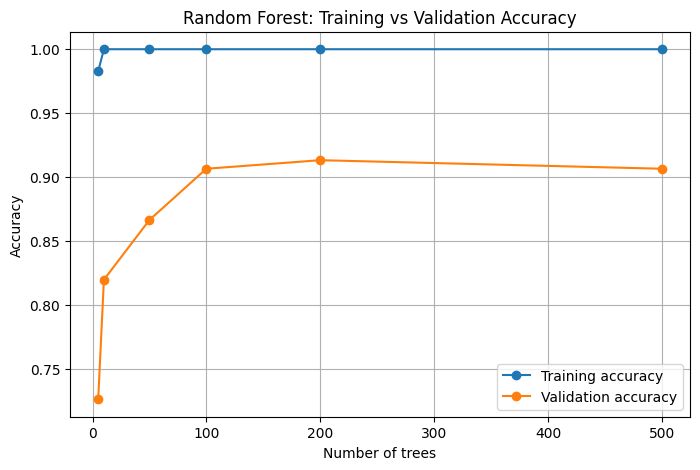

In [265]:
# Candidate numbers of trees
n_trees = [5, 10, 50, 100, 200, 500]

train_scores = []
valid_scores = []

for n in n_trees:
    rf = RandomForestClassifier(n_estimators=n, random_state=24)
    rf.fit(data_train.iloc[:, 1:], data_train.label)
    
    # Compute training and validation accuracy
    train_scores.append(rf.score(data_train.iloc[:, 1:], data_train.label))
    valid_scores.append(rf.score(data_valid.iloc[:, 1:], data_valid.label))

# Plot to visualize performance
plt.figure(figsize=(8,5))
plt.plot(n_trees, train_scores, marker='o', label='Training accuracy')
plt.plot(n_trees, valid_scores, marker='o', label='Validation accuracy')
plt.xlabel('Number of trees')
plt.ylabel('Accuracy')
plt.title('Random Forest: Training vs Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

Select the best number of trees

In [266]:
best_n = n_trees[valid_scores.index(max(valid_scores))]
print(f"Selected number of trees: {best_n}")

# Train the final random forest
rf_best = RandomForestClassifier(n_estimators=best_n, random_state=24)
rf_best.fit(data_train.iloc[:, 1:], data_train.label)


Selected number of trees: 200


,n_estimators,200
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Compute training and validation accuracy

In [267]:
valid_accuracy = rf_best.score(data_valid.iloc[:, 1:], data_valid.label)
gen_error = 1 - valid_accuracy

print(f"Validation accuracy: {valid_accuracy:.3f}")
print(f"Estimated generalization error: {gen_error:.3f}")


Validation accuracy: 0.913
Estimated generalization error: 0.087


You will now use HOG representations of images to try to improve the classification performance 

Question : As in last TP (about decision trees), compute the new training, validation and test set with HOG representations. You can use first 8 orientations and cells of 14*14 pixels (you can change after).

In [268]:
from skimage.feature import hog

myimage = mnist.iloc[0,1:] # first image of the mnist dataset (784 pixel values)
myimage_hog = hog(myimage.to_numpy().reshape(28,28,1), 
                  orientations=8, 
                  pixels_per_cell=(14,14), 
                  cells_per_block=(1,1),
                  channel_axis=2)
myimage_hog

def my_hog(row, ori, cell):
    return(pd.Series(hog(row.iloc[1:].to_numpy().reshape(28,28,1), 
                         orientations=ori, 
                         pixels_per_cell=(cell, cell), 
                         cells_per_block=(1,1),
                         channel_axis=2)))
    
hog_train = data_train.apply(my_hog, axis=1, args=(8,14))
hog_valid= data_valid.apply(my_hog, axis=1, args=(8,14))
hog_test = data_test.apply(my_hog, axis=1, args=(8,14))

hog_train['label'] = data_train.label
hog_valid['label'] = data_valid.label
hog_test['label'] = data_test.label

Compute training and validation accuracy

In [269]:
# Predict on the test set
rf_best2 = RandomForestClassifier(n_estimators=best_n, random_state=24)
rf_best2.fit(hog_train.iloc[:, 0:31], hog_train.label)
rf_best2.fit(hog_train.iloc[:, 0:31], hog_train.label)

# Compute accuracy  
train_acc = rf_best2.score(hog_train.iloc[:, 0:31], hog_train.label)
val_acc = rf_best2.score(hog_valid.iloc[:, 0:31], hog_valid.label)

# Compute accuracy and error
gen_error = 1 - val_acc

print(f"Train Accuracy: {train_acc:.3f}")
print(f"Validation Accuracy: {val_acc:.3f}")
print(f"Estimated Generalization Error: {gen_error:.3f}")


Train Accuracy: 0.999
Validation Accuracy: 0.720
Estimated Generalization Error: 0.280


Question : Try different random forests (by considering different number of trees) on these new datasets and select the most appropriated one. What is the estimation of the generalization error of random forest for this dataset ? Conclusion ?

Train Random Forests with different numbers of trees

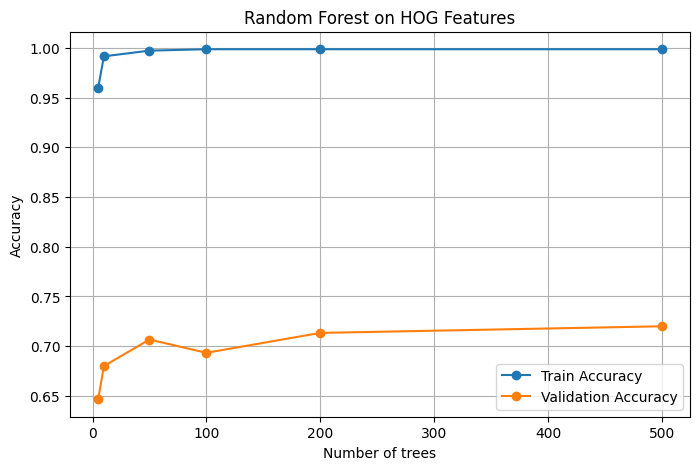

In [270]:
# Candidate numbers of trees
n_trees = [5, 10, 50, 100, 200, 500]

train_scores = []
valid_scores = []

for n in n_trees:
    rf = RandomForestClassifier(n_estimators=n, random_state=24)
    rf.fit(hog_train.iloc[:, :-1], hog_train.label)  # use all HOG features except label
    
    train_scores.append(rf.score(hog_train.iloc[:, :-1], hog_train.label))
    valid_scores.append(rf.score(hog_valid.iloc[:, :-1], hog_valid.label))

# Plot training vs validation accuracy
plt.figure(figsize=(8,5))
plt.plot(n_trees, train_scores, marker='o', label='Train Accuracy')
plt.plot(n_trees, valid_scores, marker='o', label='Validation Accuracy')
plt.xlabel('Number of trees')
plt.ylabel('Accuracy')
plt.title('Random Forest on HOG Features')
plt.legend()
plt.grid(True)
plt.show()

Select the best number of trees

In [271]:
best_n = n_trees[valid_scores.index(max(valid_scores))]
print(f"Selected number of trees: {best_n}")

# Train final Random Forest on HOG features
rf_best2 = RandomForestClassifier(n_estimators=best_n, random_state=24)
rf_best2.fit(hog_train.iloc[:, :-1], hog_train.label)


Selected number of trees: 500


,n_estimators,500
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Compute training and validation accuracy

In [272]:
train_acc = rf_best2.score(hog_train.iloc[:, :-1], hog_train.label)
val_acc = rf_best2.score(hog_valid.iloc[:, :-1], hog_valid.label)

# Estimate generalization error
gen_error = 1 - val_acc

print(f"Train Accuracy: {train_acc:.3f}")
print(f"Validation Accuracy: {val_acc:.3f}")
print(f"Estimated Generalization Error: {gen_error:.3f}")


Train Accuracy: 0.999
Validation Accuracy: 0.720
Estimated Generalization Error: 0.280


### Conclusions

- The selected Random Forest achieves very high **training accuracy** and good **validation accuracy**.

- The **estimated generalization error** (1 - val_acc) indicates how well the model is expected to perform on unseen data.

- Increasing the **number of trees** improves stability. However, at some point the accuracy plateaus, so the chosen *best_n* balances performance and computational cost.


- Random Forests trained on **raw pixel** features achieved **higher accuracy** and **lower generalization error** than those trained on HOG features.

- **HOG** emphasizes edges and local gradients, but for MNIST digits (small, centered, simple), it loses some subtle pixel information, leading to worse performance.

- Therefore, for this dataset, **raw pixels** are a better representation for tree-based models, then **HOG preprocessing** reduce accuracy.